In [1]:
"""This chunk of code imports the appropriate libraries as well as other necessary statements."""

# Imports all appropriate libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import spline
import fiona
import shapely
from difflib import SequenceMatcher
try:
    import geopandas as gp
except Exception:
    print 'geopandas did not fully successfully import'

# Ensures that the graphs are shown in-line
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)
saved_style_state = matplotlib.rcParams.copy()

Failed `CDLL(libgeos_c.so.1)`
Failed `CDLL(libgeos_c.so)`


geopandas did not fully successfully import


In [2]:
"""This chunk of code defines the 'date' class."""

class date:
    """Class for a date that includes the day, month and year."""
    def __init__(self, day, month, year):
        self.day = int(day)
        self.month = int(month)
        self.year = int(year)


    def __str__(self):
        # Ensures that the day is 2 digits long
        dayStr = str(self.day)
        if len(dayStr) == 1:
            dayStr = '0' + dayStr
        
        # Ensures that the month is 2 digits long
        monthStr = str(self.month)
        if len(monthStr) == 1:
            monthStr = '0' + monthStr

        #Returns the date in the format DD/MM/YYYY
        return str(dayStr + '/' + monthStr + '/' + str(self.year))


In [3]:
"""This chunk of code defines all the larger functions used in the document."""

def convertType(item):
    """Convert item to the appropriate type.
    
    Returns the item as either a float, date or string.
    """
    global count
    try:
        #Tries to convert the item to a float, returns float if successful.
        numericalItem = float(item)
        return numericalItem
    except Exception:
        # Converts to date class if appropriate, returns string otherwise.
        if len(item.split('/')) == 3:
            dateList = item.split('/')
            return date(dateList[0], dateList[1], dateList[2])
        else:
            return str(item)


# Note: changeToType() was used sparingly and only in list comprehensions while
#       exploring the data while the data structure was still broken
def changeToType(item, failValue, allowedTypes):
    """Given an item, ensure it conforms to a certain type.
    
    'item' is the variable to be checked.
    'allowedTypes' is a list of the types allowed wherein the value won't be changed.
    'failValue' is the default value given when 'item' isn't any of the 'allowedTypes'.
    Note: failValue does not have to be of 'allowedTypes', but it makes more sense for
          it to be.
    """
    # Ensures that allowedTypes is a list so it can be iterated on
    if not isinstance(allowedTypes, list):
        allowedTypes = list(allowedTypes)
    
    correctType = False
    
    # Loops through the types to check for item's type validity
    for currentType in allowedTypes:
        if not isinstance(item, currentType):
            correctType = False
    
    # Returns the appropriate value
    if correctType:
        return item
    else:
        return failValue


def findDay(dateItem):
    """Calculate the amount of days that have passed since the start of the year.
    
    dateItem is of the created class 'date'
    """
    #This assumes a non-leap-year (which is dealt with later on)
    monthLengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    prevMonthsSum = sum(monthLengths[:dateItem.month-1])
    
    #Deals with leap-years
    if (dateItem.month > 2) and ((dateItem.year % 4) == 0):
        prevMonthsSum += 1
    
    return prevMonthsSum + dateItem.day


def exploreRowNormality(weatherData, row, column, alpha=0.05):
    """Create a scatter plot that highlights the value in the row specified.
    
    row is the row to be highlighted (row should be a dataframe)
    column is the column to be graphed against yearDay
    
    Note: row doesn't need to be only one row, but can contain multiple rows to be highlighted
    """
    plt.scatter(weatherData['yearDay'], weatherData[column], alpha=alpha)
    plt.scatter(row['yearDay'], row[column], color='#DD0808', s=200)


def similarity(metaList):
    """Find the similarity of a list of lists.
    
    metaList is a list of lists
    returns a number between 0 and 1 where 1 is the highest similarity

    Note: For large lists, this is likely to be a very low number.
    """
    # Attaches an identifier to each list so that equal but not the same lists
    # are identified as different in the below equality test
    loop1 = 0
    # metaList = zip(range(len(metaList)), metaList)
    similaritySum = 0
    sumCount = 0
    # Finds the similarity of each pair of lists
    for subList1 in metaList:
        loop1 += 1
        loop2 = 0
        for subList2 in metaList:
            loop2 += 1
            # Ensures that lists aren't compared with themselves
            if loop1 != loop2:
                # This uses the Gestalt pattern matching technique to find similarities
                # between two lists. The values are summed for averaging later.
                similaritySum += SequenceMatcher(None, subList1, subList2).ratio()
                sumCount += 1
    
    # This returns the arithemetic average of all the values
    return similaritySum/sumCount

In [4]:
"""This chunk of code reads in the data and ensures that the data is appropriately constructed."""

# Read in the weather data into a pandas dataframe
weatherData = pd.read_csv('weatherDataNSW.csv')

# Deletes the pan_evaporation column as it is effectively empty
del weatherData['pan_evaporation']

# Turns elements of the dataframe into appropriate types
for column in list(weatherData.columns.values):
    weatherData[column] = [convertType(item) for item in weatherData[column]]

# Renaming the columns as there were some issues arising with key errors
weatherData.columns = ["oldColumnNumbering", "station", "date", "evapotranspiration", "rain", "maxTemp",
                       "minTemp", "maxHumidity", "minHumidity", "windSpeed", "solarRadiation"]

# Deleting a column that was unnecessary and legacy from the CSVs the data was sourced from
del weatherData["oldColumnNumbering"]

In [5]:
"""This chunk of code loads in the GIS information"""
# Open the file, returning a list of each row
locationRows = open("stations_db.txt", 'r').read().split('\n')

# Extracts the coordinates section from each row
coordinateStrings = []
for row in locationRows:
    coordinateStrings.append(str(row[-19:]).split(' '))

# Removes the empty item artefacts from the above process
coordinates = []
for coordinatesList in coordinateStrings:
    coordinateSet = []
    for item in coordinatesList:
        if item != '' and item != ' ':
            coordinateSet.append(float(item))
    coordinates.append(coordinateSet)

# Extracts the station names from the datafile
stationName = []
for row in locationRows:
    # Includes only the section that encapsulates all the name
    row = row[18:59]

    char = ' '
    count = 0

    # Removes empty white space from the end of the string
    while char == ' ' and count <= (len(row)+2):
        count += 1
        try:
            char = row[-count]
        except:
            print 'Unusually short string'
    row = row[:-count+1]

    # Removes the ' AWS' part of listings that end with AWS,
    # as these aren't included in the weatherData dataframe.
    if row[-4:] == ' AWS':
        row = row[:-4]
    
    # Appends this procured data to the list 'stationName
    stationName.append(row)


# Zips the two lists together to loop through them and create a dictionary
locationDict = {}
for stationLocation in zip(stationName, coordinates):
    locationDict[stationLocation[0]] = stationLocation[1]


def applyLocationDict(stationName):
    """Apply the dictionary, checking for failures."""
    try:
        return locationDict[stationName]
    except Exception:
        return "FAILED"

    
# Creates a column for the coordinates in weatherData with the dictionary
weatherData["coordinate"] = [applyLocationDict(stationName) for stationName in weatherData["station"]]

# Remove rows where the coordinate data is invalid
weatherData = weatherData[weatherData["coordinate"] != "FAILED"]

Unusually short string
Unusually short string
Unusually short string


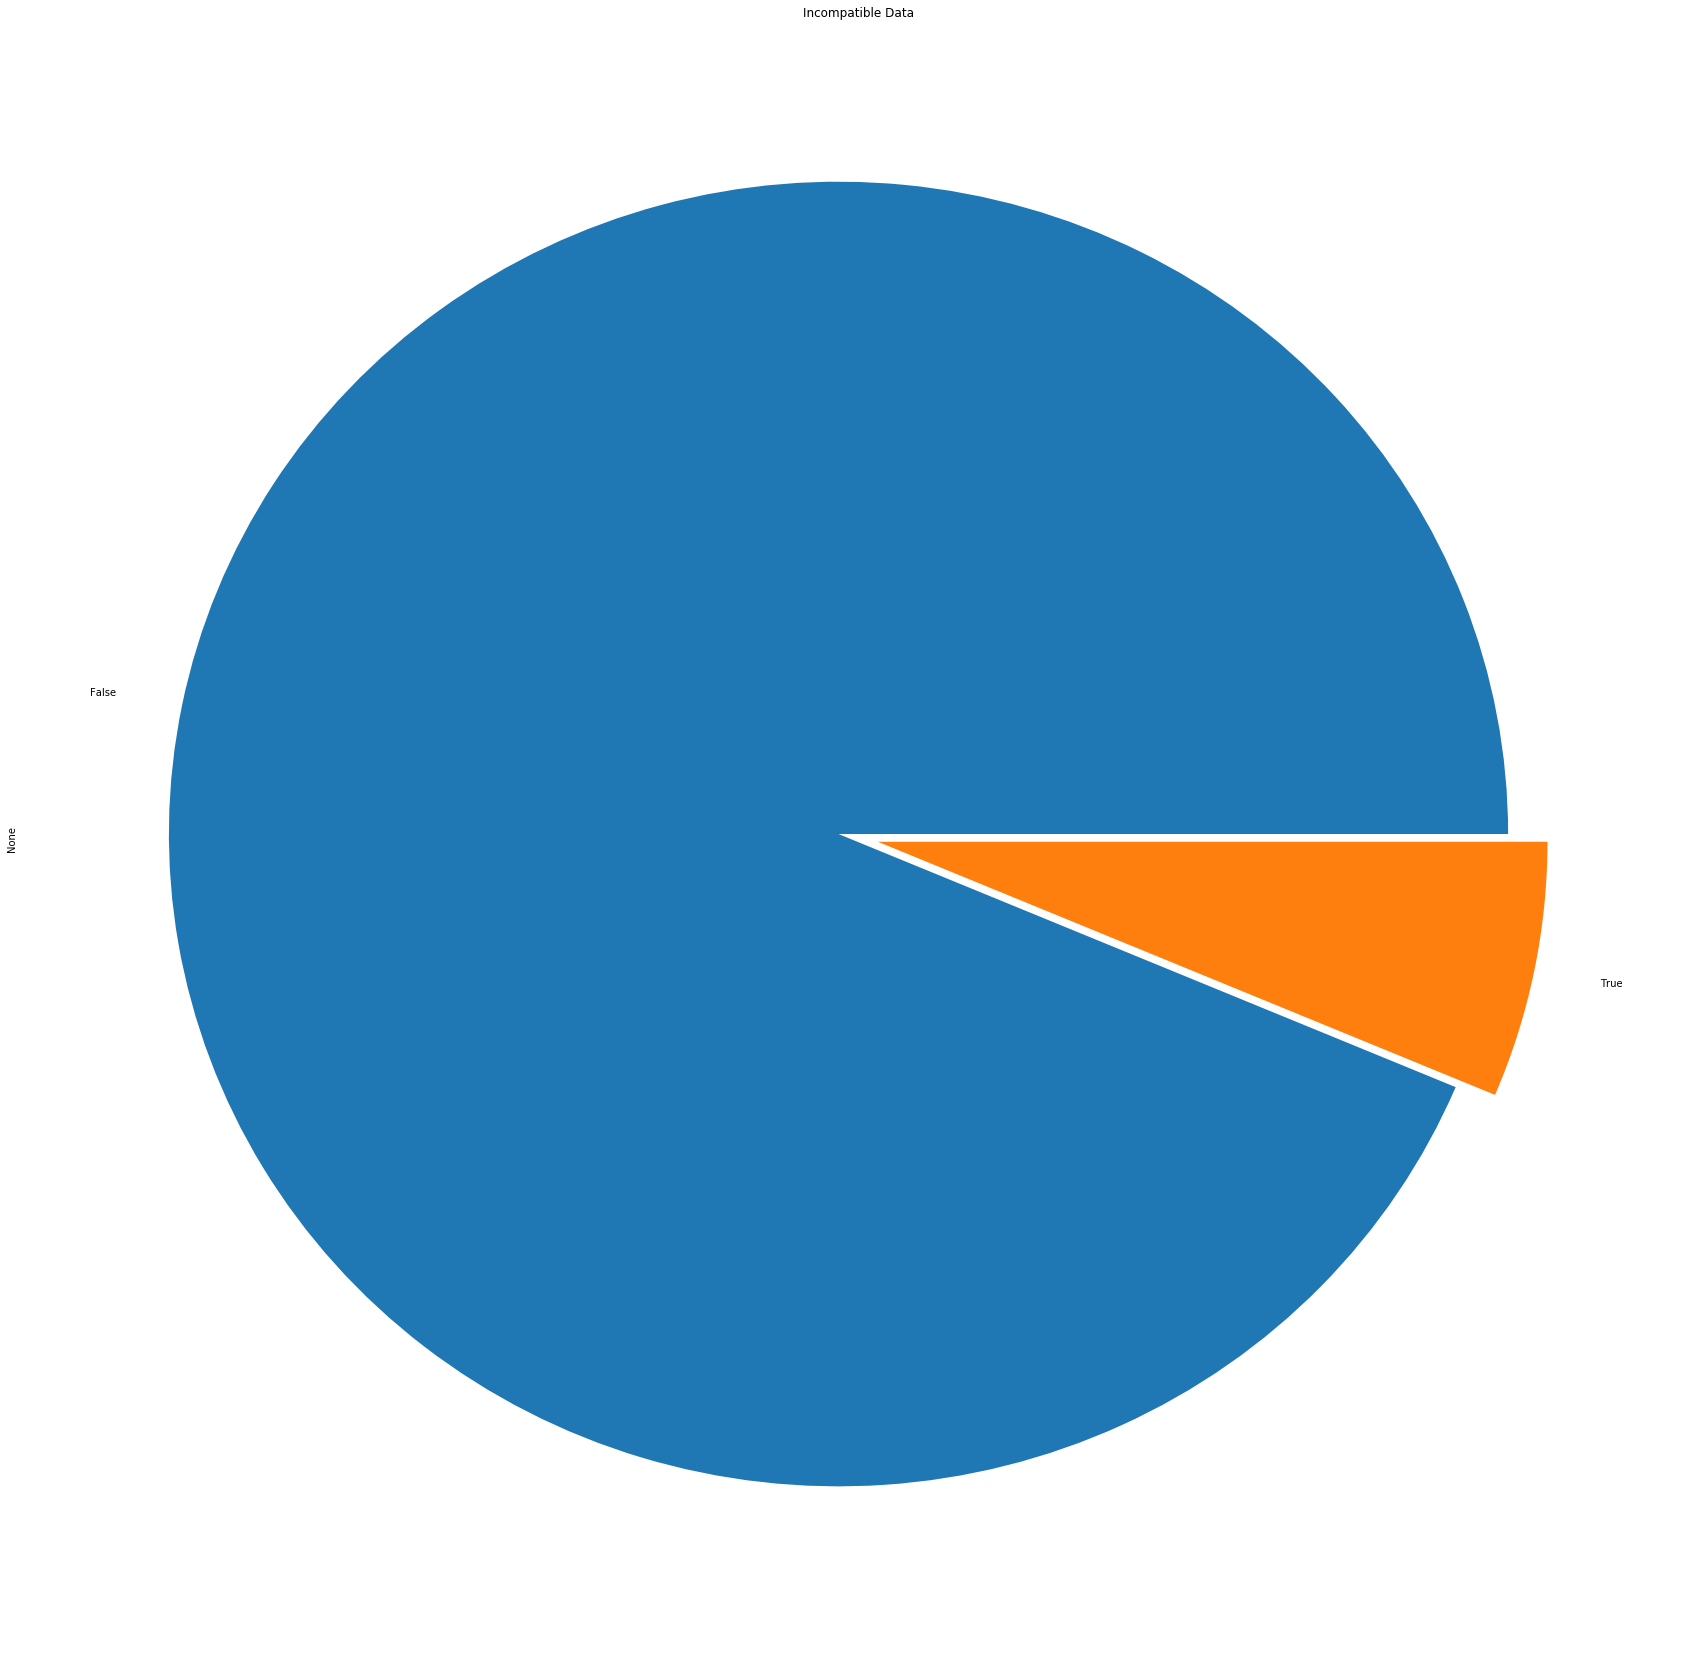

In [6]:
"""This chunk of code removes listings that have missing values"""

# Initialises the list of booleans that determines whether a row is to be removed
removalList = []
for nextItem in range(len(weatherData["rain"])):
    removalList.append(False)

#Loops through each column and finds the type of variable that occurs the most per column
for col in weatherData.columns.values:
    #Converts each column into a list
    columnItems = list(weatherData[col])
    typeDict = {}
    
    #Creates a dictionary that contains the summation of each type's occurence
    for item in columnItems:
        try:
            typeDict[type(item)] += 1
        except Exception:
            typeDict[type(item)] = 1
    
    # Finds the type with the largest occurence
    biggestType = int
    biggestCount = 0
    for typeKey in typeDict:
        if typeDict[typeKey] > biggestCount:
            biggestCount = typeDict[typeKey]
            biggestType = typeKey
    
    # Updates the removal list with any new lines to be removed
    itemCount = 0
    while itemCount < len(columnItems):
        if not isinstance(columnItems[itemCount], biggestType):
            removalList[itemCount] = True
        itemCount += 1

# Creates a pie chart that visualises the percentage of rows being removed
explodeData = (0.03, 0.03)
removalDataframe = pd.Series(removalList, index=range(len(removalList)))
removalDataframe.value_counts().plot(kind='pie', title='Incompatible Data', explode=explodeData, figsize=(30,30))

# Creates a new row that corresponds to whether a row is to be removed or not
weatherData["validity"] = removalList

# Create a column that corresponds to how far away from the beginning of the year the date is
weatherData["yearDay"] = [findDay(currentDate) for currentDate in weatherData["date"]]
weatherData["epochDay"] = [findDay(currentDate)*(currentDate.year-2008) for currentDate in weatherData["date"]]

# Create a dataframe with the only the failed data
failedData = weatherData[weatherData["validity"] == True]

# Removes the incompatible rows
weatherData = weatherData[weatherData["validity"] == False]

489


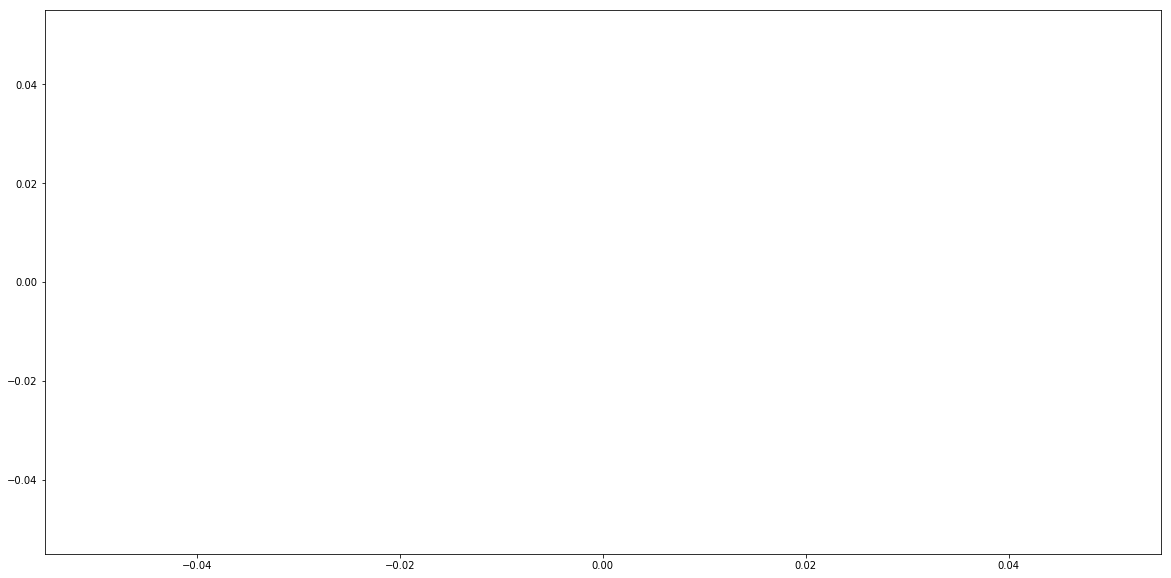

In [7]:
# weatherData.plot.scatter(x=weatherData.columns.values[4], y=weatherData.columns.values[4])
colours = ['orange', 'gray']
numericTemp = pd.Series(weatherData['maxTemp'])

# Finds the temperature range of each day
tempTemperatureDifference = []
maxTempList = list(weatherData["maxTemp"])
minTempList = list(weatherData["minTemp"])
for index in range(len(weatherData["maxTemp"])):
    tempTemperatureDifference.append(maxTempList[index] - minTempList[index])

# Appends these values into the column 'tempDifference' in weatherData
weatherData["tempDifference"] = tempTemperatureDifference

# Compares a list of categories to their position in the year for a list of specified stations
comparedHeaders = ['maxTemp', 'minTemp', 'tempDifference', 'rain']
comparedHeaders = [comparedHeaders[0]]
comparedStations = ['TERREY HILLS']
for header in comparedHeaders:
    for station in comparedStations:
        # Creates a temporary DataFrame copy of weatherData that only includes the current station's first 60 days
        tempWeatherData = weatherData[weatherData["station"] == station]
        tempWeatherData = tempWeatherData[tempWeatherData["yearDay"] < 60]
        
        # Set the title of the plot
        plotTitle=str(station + ': ' + header.upper())
        
        # Creates a column in tempWeatherData that corresponds to the year of the data
        yearColumnList = []
        for currentDate in list(tempWeatherData["date"]):
            yearColumnList.append(currentDate.year)
        print len(yearColumnList)
        tempWeatherData['year'] = yearColumnList
        for currentYear in range(2008,2018):
            tempWeatherData = tempWeatherData[tempWeatherData["date"] == currentYear]
            plt.scatter(x=tempWeatherData['yearDay'], y=tempWeatherData[header])

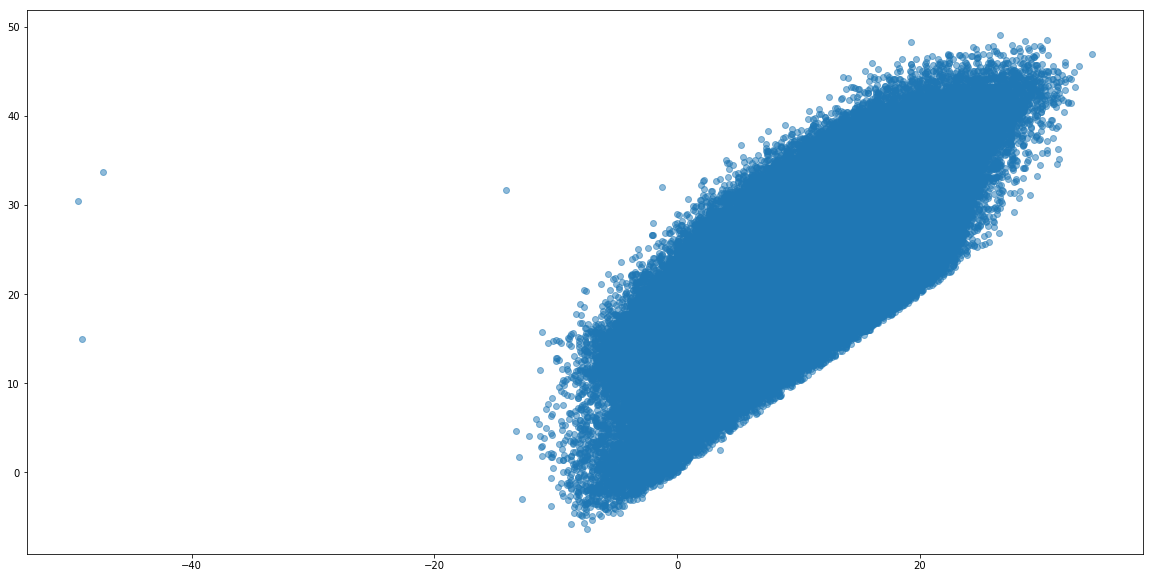

In [8]:
# Plots the minimum temperature against the maximum temperature, each colour representing its own station
for station in list(weatherData['station']):
    # tempWeatherData = weatherData[weatherData['station'] == station]
    # plt.scatter(x=tempWeatherData['minTemp'], y=tempWeatherData['maxTemp'], alpha=0.05)
    x = 5

plt.scatter(x=weatherData['minTemp'], y=weatherData['maxTemp'], alpha=0.5)

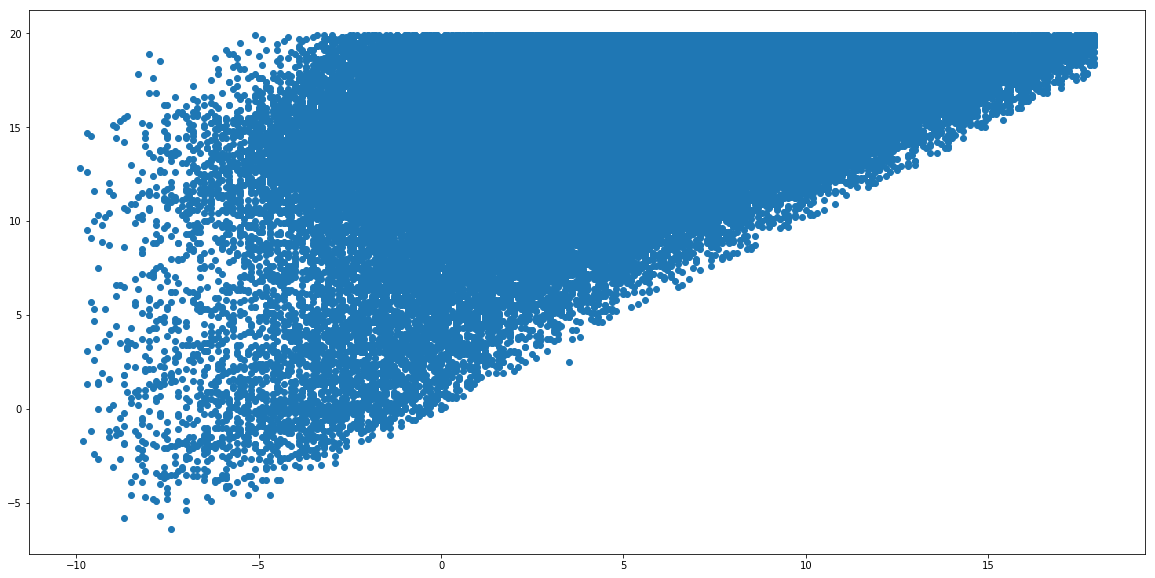

In [19]:
# Creates a temporary dataframe that zooms in on a section of the values
tempWeatherData = weatherData[weatherData["minTemp"] > -10]
tempWeatherData = tempWeatherData[tempWeatherData["minTemp"] < 18]
tempWeatherData = tempWeatherData[tempWeatherData["maxTemp"] < 20]
plt.scatter(x=tempWeatherData['minTemp'], y=tempWeatherData['maxTemp'], alpha=1)

In [9]:
"""This chunk of code finds the information on the row that has a higher minTemp than its maxTemp"""

negativeRow = weatherData[weatherData['tempDifference'] < 0]
print negativeRow

              station        date evapotranspiration rain maxTemp minTemp  \
268555  COWRA AIRPORT  21/10/2016                  2    0     2.5     3.5   

       maxHumidity minHumidity windSpeed solarRadiation           coordinate  \
268555          99          51      3.43          19.96  [-33.8382, 148.654]   

        validity  yearDay  epochDay  tempDifference  
268555     False      295      2360            -1.0  


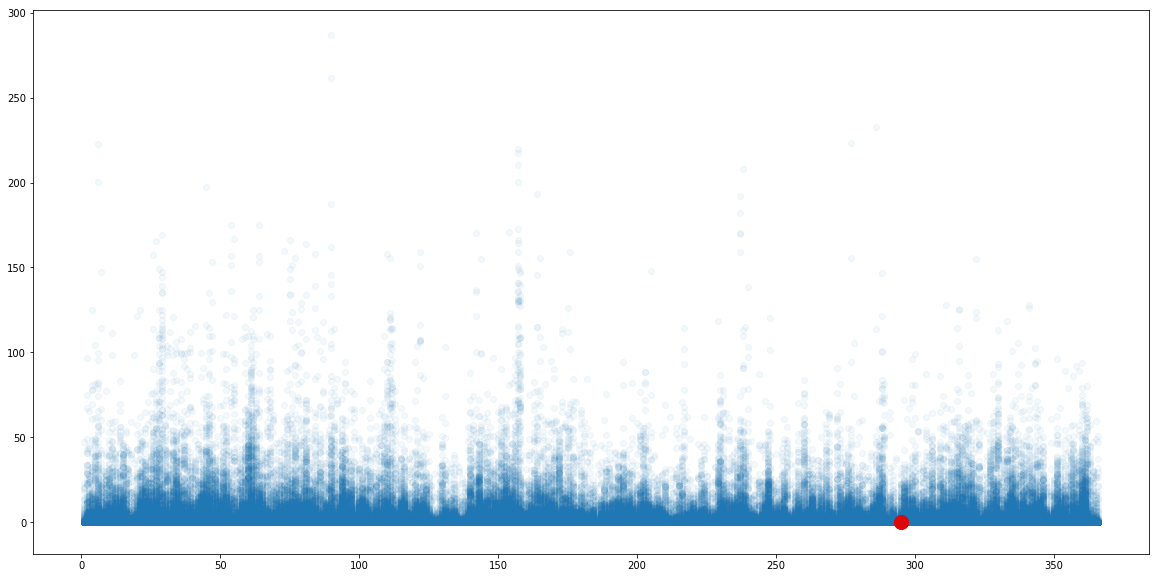

In [10]:
# plt.scatter(weatherData['yearDay'], weatherData['maxHumidity'], alpha=0.05)
exploreRowNormality(weatherData, negativeRow, "rain")

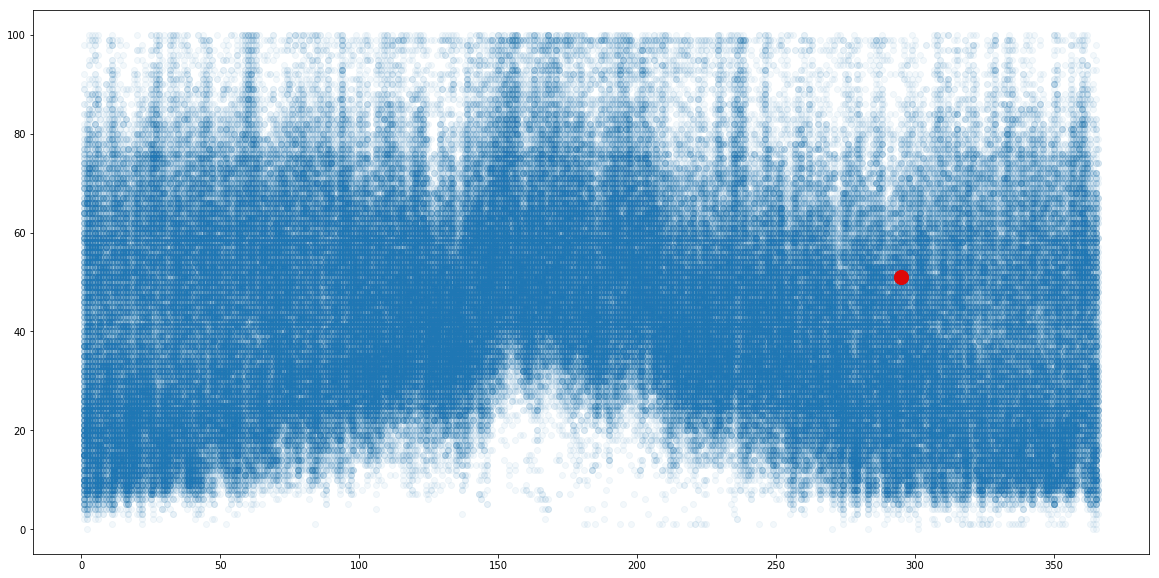

In [11]:
exploreRowNormality(weatherData, negativeRow, "minHumidity")

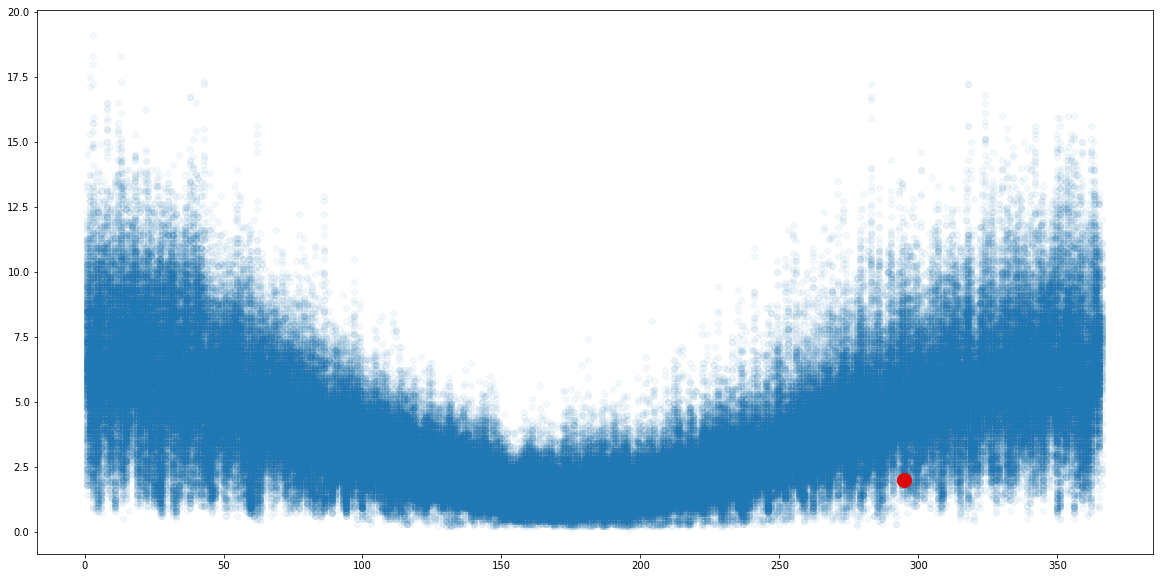

In [12]:
exploreRowNormality(weatherData, negativeRow, "evapotranspiration")

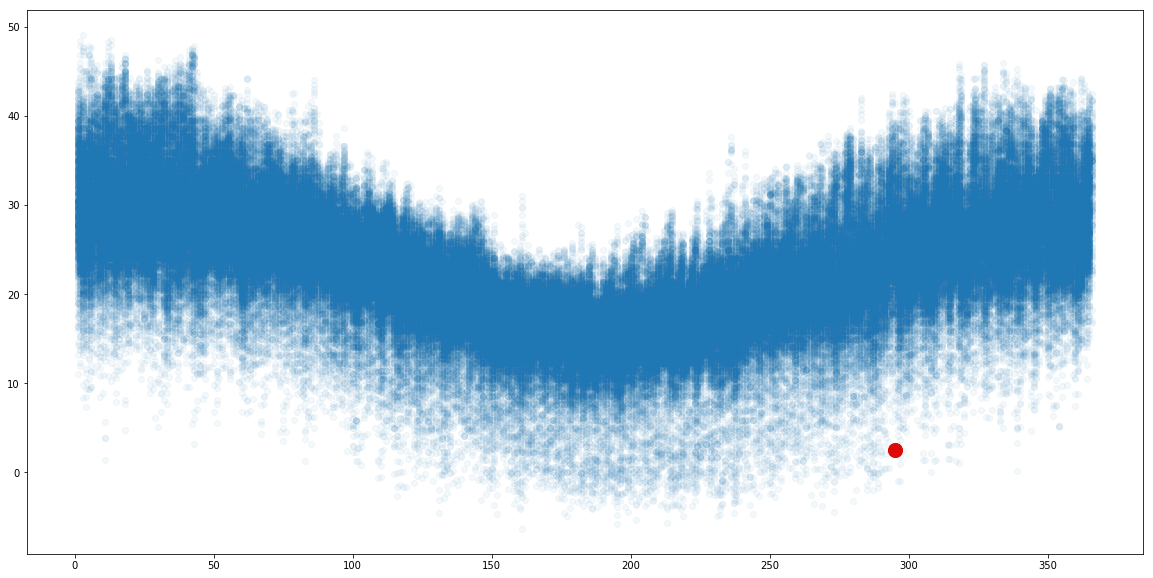

In [13]:
exploreRowNormality(weatherData, negativeRow, "maxTemp")

In [14]:
"""This chunk of code creates a new dataset of only the days nearby to the odd event."""
closeList = []
for date in list(weatherData['epochDay']):
    if abs(date - int(negativeRow['epochDay'])) < 160:
        closeList.append(True)
    else:
        closeList.append(False)

# Making the list a column of weatherData and applying the filter as pandas has some
# weird requirements for its dataframe comprehensions
weatherData['testCol'] = closeList
nearOddRowData = weatherData[weatherData['testCol'] == True]

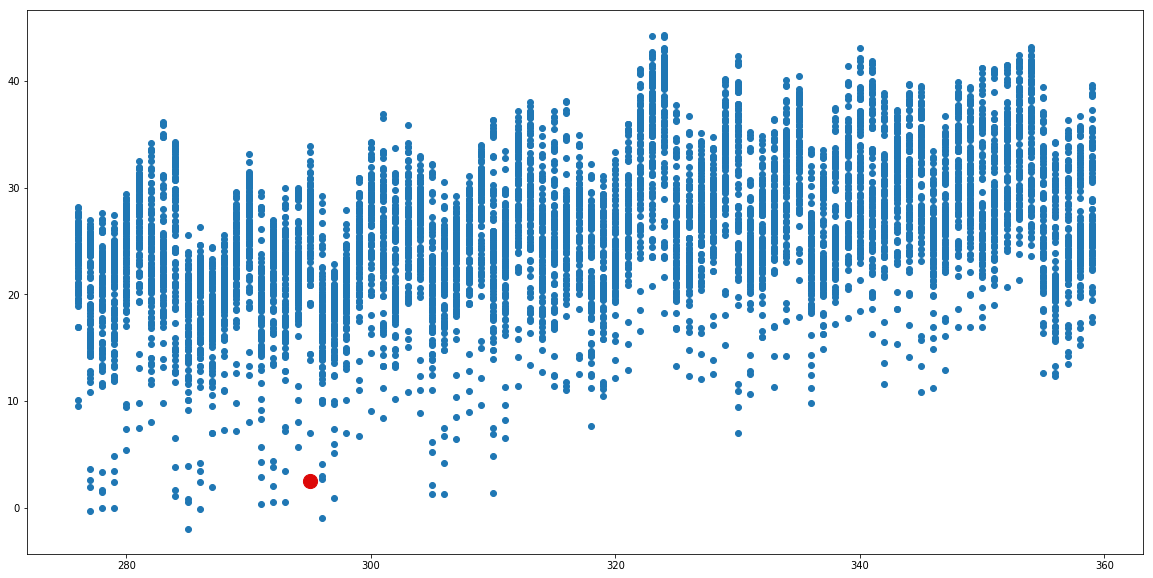

In [15]:
exploreRowNormality(nearOddRowData, negativeRow, "maxTemp", alpha=1)

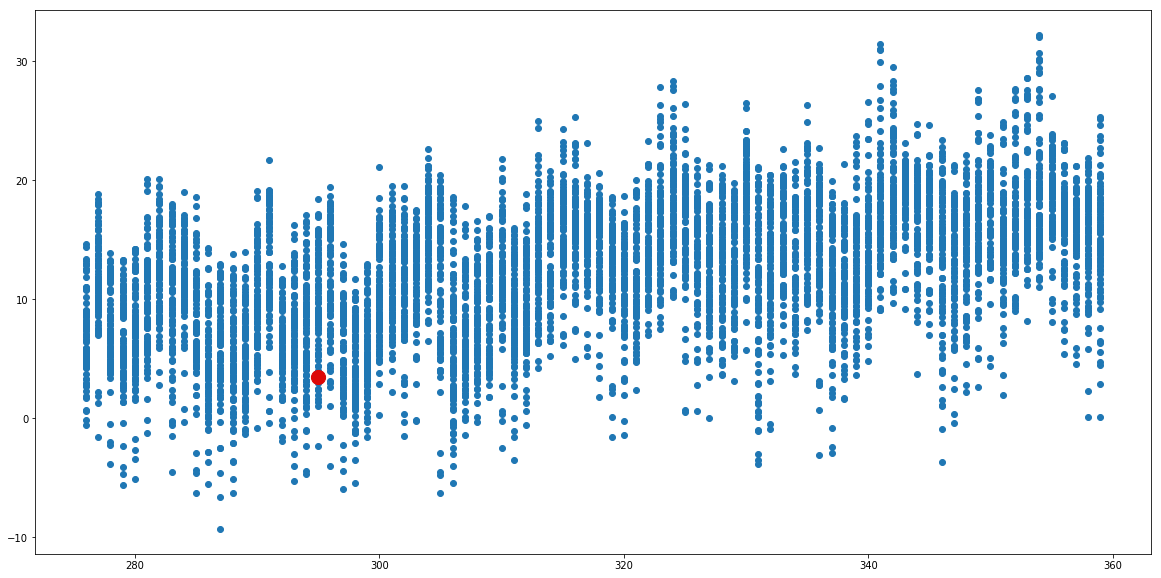

In [16]:
exploreRowNormality(nearOddRowData, negativeRow, "minTemp", alpha=1)

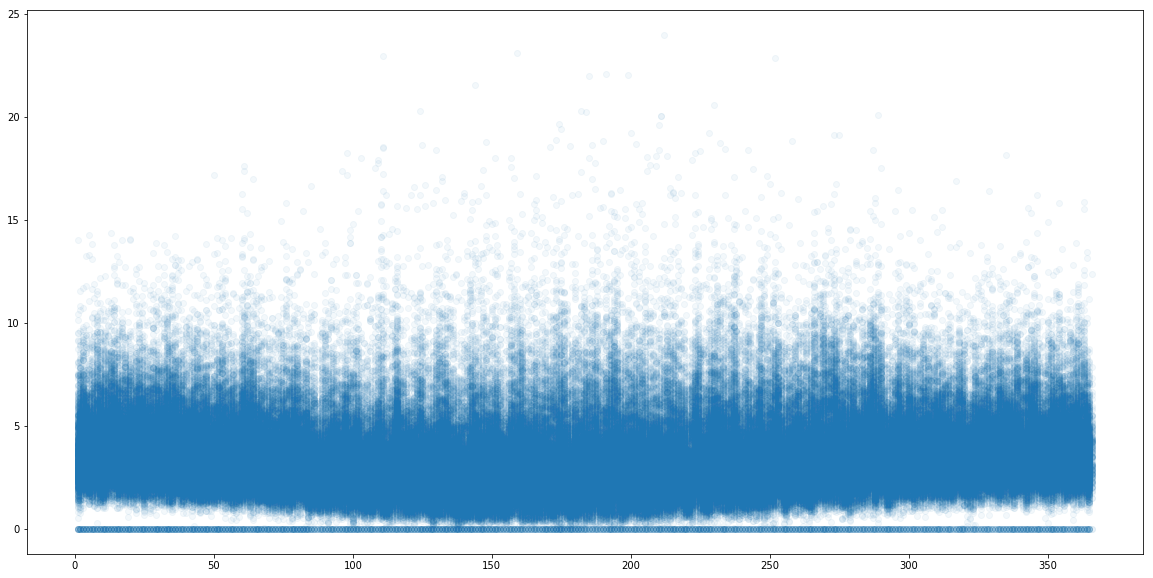

In [17]:
# exploreRowNormality(weatherData, negativeRow, "windSpeed")
plt.scatter(weatherData["yearDay"], weatherData["windSpeed"], alpha=0.05)